코드 원본 출처 https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

### 패키지 임포트

In [1]:
import numpy as np
import pandas as pd
import re
import spacy
import gensim
from tqdm.notebook import tqdm

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.lda_model # pyLDAvis 3.4.0부터 .sklearn 없어짐! 대신 .lda_model 동일 기능 사용 가능
# https://stackoverflow.com/questions/76836793/jupyter-notebook-cannot-import-pyldavis-sklearn
import matplotlib.pyplot as plt
%matplotlib inline


#### 문서 데이터셋 로드

In [2]:
df = pd.read_csv("C:/Users/user/code/kka/2018_22 산림복지/2018산림복지 본문to명사+정제1012.txt", sep='\t', encoding='UTF-8')
print(df.shape, df.columns)
df.head()

(4786, 3) Index(['org_idx', '문서to명사', '문서to명사_정제'], dtype='object')


,org_idx,문서to명사,문서to명사_정제
0,0,블로그 개 글 목록 열기 영어 명언 모음 영어 명언 모음 문장 영어 명언 적 자신 ...,목록 영어 명언 모음 영어 명언 모음 문장 영어 명언 자신 사랑 인생 환희 현재 두...
1,1,인사말 인사말 장애인 날 첫 회 시작 배리어프리 영화 소개 코너 소개 코너 소개 배...,인사말 인사말 장애인 시작 배리어프리 영화 소개 코너 소개 코너 소개 배리어프리 소...
2,2,블로그 게시판 개 글 게시판 목록 열기 콩 그 마취 일정 기간 지나 게시판 지난해 ...,게시판 게시판 목록 마취 일정 기간 지나 게시판 지난해 국가 복리 후생 봉사 사업 ...
3,3,블로그 복지 단체 자선가 개 글 복지 단체 자선가 목록 복지 단체 자선가 글 목록 ...,단체 자선가 단체 자선가 목록 단체 자선가 목록 작성 강태원 재단 인턴 인력 모집 ...
4,4,급 항만 경제 전략 국장 병수 도시 주택 국장 손정호 급 항만 정책 과장 정형민 성...,항만 경제 전략 국장 병수 도시 주택 국장 손정호 항만 정책 과장 정형민 성장 전략...


In [3]:
nouns = list(df['문서to명사_정제'])
print(len(nouns))

4786


In [4]:
find_nan = [i for i in range(len(nouns)) if type(nouns[i]) == float]
print(len(find_nan), find_nan[:10])
# for idx in find_nan:
#     print(nouns[idx])


0 []


In [6]:
for idx in find_nan:
    nouns[idx] = 'notext'

In [7]:
find_nan2 = [i for i in range(len(nouns)) if type(nouns[i]) == float]
print(len(find_nan2), find_nan2[:10])

0 []


#### 불용어 데이터셋 로드

In [8]:
pronoundf = pd.read_csv("C:/Users/user/Documents/jupyter_notebook/한국어 대명사 목록.txt", sep='\t', encoding='UTF-8')
adverbdf = pd.read_csv("C:/Users/user/Documents/jupyter_notebook/한국어 부사 목록.txt", sep='\t', encoding='UTF-8')
josadf = pd.read_csv("C:/Users/user/Documents/jupyter_notebook/한국어 조사 목록.txt", sep='\t', encoding='UTF-8')
kor_pronoun = pronoundf['대명사'].to_list()
kor_adverb = adverbdf['부사'].to_list()
kor_josa = josadf['조사'].to_list()
kor_stopwords = sorted(list(set(kor_pronoun + kor_adverb + kor_josa)))
print(len(kor_stopwords), kor_stopwords[:10])


530 ['가', '가까이', '가끔', '같이', '같이나', '같이는', '같이는야', '같이는커녕', '같이도', '같이만']


#### 데이터 전처리
1. 정규표현식으로 데이터 정제 - 산림복지 이미 해서 할 필요 없음.
2. 토큰화=형태소화 및 문장부호 없애기
3. Lemmatization 표제어 추출 : am, are, is, were 의 표제어는 be

#### Document-Word matrix 만들기

In [5]:
vectorizer = CountVectorizer(analyzer='word',       
                            #  min_df=10,                         # minimum reqd occurences of a word
                            #  stop_words=kor_stopwords,          # remove stop words
                             lowercase=True,                    # convert all words to lowercase
                            #  token_pattern=r"(?u)\b\w+\b",      # num chars 1도 포함
                            )


In [6]:
data_vectorized = vectorizer.fit_transform(nouns)

#### LDA 모델 만들기

#### Perplexity, Log-likelihood, Coherence로 모델 성능 진단

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
def calc_pv_coherence(countVector,vocab, start=5, end=20, max_iter=10,topic_wp=0.1, doc_tp=1.0):
    num = []
    per_value = []
    cor_value = []
    learning_decay_list = [0.5,0.6,0.7,0.8,0.9,1.0]
    for i in tqdm(range(start,end+1)):
        for j in tqdm(range(len(learning_decay_list))):
            lda = LatentDirichletAllocation(n_components=i,max_iter=max_iter,
                                        topic_word_prior=topic_wp,
                                        doc_topic_prior=doc_tp,
                                        learning_method='online',
                                        learning_decay = learning_decay_list[j],
                                        n_jobs=-1,
                                        random_state=123)
            lda.fit(countVector)
            num.append(i)
            pv = lda.perplexity(countVector)
            per_value.append(pv)
            coherence_score = metric_coherence_gensim(measure='u_mass',
                                                    top_n=10,
                                                    topic_word_distrib=lda.components_,
                                                    dtm=countVector,
                                                    vocab=vocab,
                                                    texts=None)
            cor_value.append(np.mean(coherence_score))
        
            print(f'토픽 수: {i}, 학습률: {learning_decay_list[j]}, 혼란도: {pv:0.4f}, 응집도:{np.mean(coherence_score):0.4f}')

    plt.plot(num,per_value,'g-')
    plt.xlabel("num of topic:")
    plt.ylabel("Perplexity: ")
    plt.show()
    
    plt.plot(num,cor_value,'r--')
    plt.xlabel("num of topic:")
    plt.ylabel("Coherence: ")
    plt.show()
    return per_value,cor_value

In [17]:
vocab = vectorizer.get_feature_names_out()
# per_values, cor_values = calc_pv_coherence(data_vectorized,vocab,start=5,end=20)
calc_pv_coherence(data_vectorized,vocab,start=5,end=20)


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

토픽 수: 5, 학습률: 0.5, 혼란도: 3718.4088, 응집도:-1.3516
토픽 수: 5, 학습률: 0.6, 혼란도: 3636.3609, 응집도:-1.4309
토픽 수: 5, 학습률: 0.7, 혼란도: 3593.0347, 응집도:-1.2322
토픽 수: 5, 학습률: 0.8, 혼란도: 3589.8024, 응집도:-1.2618
토픽 수: 5, 학습률: 0.9, 혼란도: 3621.6168, 응집도:-1.2599
토픽 수: 5, 학습률: 1.0, 혼란도: 3703.2312, 응집도:-1.4203


  0%|          | 0/6 [00:00<?, ?it/s]

토픽 수: 6, 학습률: 0.5, 혼란도: 3612.7233, 응집도:-1.6430


#### 최고 성능 LDA 모델 GridSearch

In [17]:
n_range = list(range(5,20,1))
print(type(n_range), len(n_range))
print(n_range)


<class 'list'> 11
[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [28]:
lda_model = LatentDirichletAllocation(n_components=10,
                                       max_iter=10,               # Max learning iterations
                                       topic_word_prior=0.1,
                                       doc_topic_prior=1.0,
                                       learning_method='batch',
                                       random_state=123,          # Random state
                                       evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                       n_jobs = -1,               # Use all available CPUs
                                     )
# lda_output = lda_model.fit_transform(data_vectorized)


In [29]:
%%time
# Define Search Param
search_params = {'n_components': list(range(5,21,1)), 'learning_decay': [0.5,0.6,0.7,0.8,0.9,1.0]}

# Init the Model
# lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda_model, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

#### 가장 성능이 뛰어난 토픽 모델의 파라미터 확인하기

In [19]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 7}
Best Log Likelihood Score:  -10361723.6122627
Model Perplexity:  3414.3018101481302


In [20]:
import pickle 
with open('D:/2018-22산림복지/산림복지 토픽모델링/2022산림복지_LDA_GS_1차.pickle','wb') as fw:
    pickle.dump(best_lda_model, fw)

In [ ]:
import numpy as np
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
vocab = vectorizer.get_feature_names_out()
coherence_score = metric_coherence_gensim(measure='u_mass',
                                            top_n=10,
                                            topic_word_distrib=best_lda_model.components_,
                                            dtm=data_vectorized,
                                            vocab=vocab,
                                            texts=None)

print(np.mean(coherence_score))


In [ ]:
def metric_coherence_gensim(measure, topic_word_distrib=None, gensim_model=None, vocab=None, dtm=None,
                            gensim_corpus=None, texts=None, top_n=20,
                            return_coh_model=False, return_mean=False, **kwargs):


#### LDA 모델 성능 비교

In [ ]:
#### numpy 출력 결과 생략 없이 전부 출력 설정 코드
# np.set_printoptions(threshold=np.inf, linewidth=np.inf)

In [ ]:
# print(model.cv_results_)
model.cv_results_


In [21]:
for g_score in model.cv_results_:
    if g_score == 'mean_test_score':
        print('{} 값:'.format(g_score), model.cv_results_[g_score])
    elif g_score == 'params':
        for i in range(len(model.cv_results_[g_score])):
            print('인덱스는 {} :'.format(i), model.cv_results_[g_score][i])


인덱스는 0 : {'learning_decay': 0.5, 'n_components': 5}
인덱스는 1 : {'learning_decay': 0.5, 'n_components': 6}
인덱스는 2 : {'learning_decay': 0.5, 'n_components': 7}
인덱스는 3 : {'learning_decay': 0.5, 'n_components': 8}
인덱스는 4 : {'learning_decay': 0.5, 'n_components': 9}
인덱스는 5 : {'learning_decay': 0.5, 'n_components': 10}
인덱스는 6 : {'learning_decay': 0.5, 'n_components': 11}
인덱스는 7 : {'learning_decay': 0.5, 'n_components': 12}
인덱스는 8 : {'learning_decay': 0.5, 'n_components': 13}
인덱스는 9 : {'learning_decay': 0.5, 'n_components': 14}
인덱스는 10 : {'learning_decay': 0.5, 'n_components': 15}
인덱스는 11 : {'learning_decay': 0.7, 'n_components': 5}
인덱스는 12 : {'learning_decay': 0.7, 'n_components': 6}
인덱스는 13 : {'learning_decay': 0.7, 'n_components': 7}
인덱스는 14 : {'learning_decay': 0.7, 'n_components': 8}
인덱스는 15 : {'learning_decay': 0.7, 'n_components': 9}
인덱스는 16 : {'learning_decay': 0.7, 'n_components': 10}
인덱스는 17 : {'learning_decay': 0.7, 'n_components': 11}
인덱스는 18 : {'learning_decay': 0.7, 'n_components'

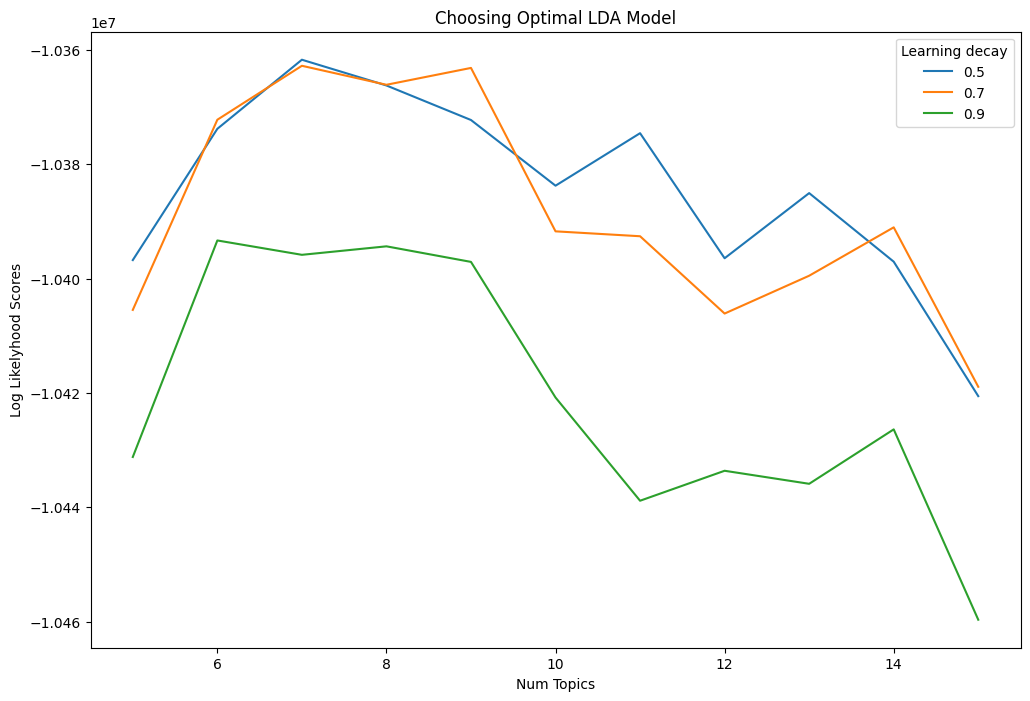

In [22]:
# Get Log Likelyhoods from Grid Search Output
# n_topics = [5, 10, 15, 20]
n_topics = list(range(5,16,1))
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][i]) for i in range(0,11)]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][i]) for i in range(11,22)]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][i]) for i in range(22,33)]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

#### 개별 문서의 주요 토픽 파악

In [23]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(nouns))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,dominant_topic
Doc0,0.110000,0.060000,0.830000,0.000000,0.000000,0.000000,0.000000,2
Doc1,0.580000,0.200000,0.180000,0.040000,0.000000,0.000000,0.000000,0
Doc2,0.020000,0.230000,0.030000,0.000000,0.020000,0.000000,0.700000,6
Doc3,0.000000,0.000000,0.170000,0.000000,0.000000,0.830000,0.000000,5
Doc4,0.000000,0.240000,0.700000,0.000000,0.050000,0.000000,0.000000,2
Doc5,0.330000,0.430000,0.050000,0.080000,0.110000,0.000000,0.000000,1
Doc6,0.070000,0.790000,0.010000,0.000000,0.010000,0.100000,0.020000,1
Doc7,0.740000,0.080000,0.000000,0.130000,0.040000,0.000000,0.010000,0
Doc8,0.780000,0.020000,0.000000,0.150000,0.060000,0.000000,0.000000,0
Doc9,0.030000,0.070000,0.000000,0.000000,0.010000,0.880000,0.000000,5


#### 문서의 토픽 분포 파악

In [24]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,2,2597
1,4,2287
2,0,2210
3,1,992
4,6,610
5,5,435
6,3,162


#### pyLDAvis로 LDA 모델 시각화하기

In [27]:
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0     -120.845528   -6.706859       1        1  19.869416
4       10.909354   20.434378       2        1  19.050539
1       52.888851  148.254852       3        1  18.593034
2      142.310745   47.867760       4        1  14.983363
6      -78.589050  120.976242       5        1  12.463088
3      100.480469  -80.225174       6        1   8.440224
5      -31.374443 -107.367378       7        1   6.600336, topic_info=      Term          Freq         Total Category  logprob  loglift
31150   산림  39029.000000  39029.000000  Default  30.0000  30.0000
71302   학과  12306.000000  12306.000000  Default  29.0000  29.0000
36782    숲  24229.000000  24229.000000  Default  28.0000  28.0000
30767   사업  29300.000000  29300.000000  Default  27.0000  27.0000
71355   학부   8083.000000   8083.000000  Default  26.0000  26.0000
...    ...           ...           ...      ...      ...      ...
69221   평가   2231.837008   6975.964129   Topic7  -5.1805   1.5784
37937  시스템   2061.910796   5260.887617   Topic7  -5.2597   1.7814
59721   지역   2356.138446  24059.776129   Topic7  -5.1263   0.3945
31029   사회   2105.740112  15690.712345   Topic7  -5.2386   0.7096
74862   환경   1883.291436  13686.270986   Topic7  -5.3503   0.7347

[545 rows x 6 columns], token_table=       Topic      Freq Term
term                       
310        5  0.999007   가액
385        1  0.212123   가장
385        2  0.002314   가장
385        3  0.616120   가장
385        4  0.063251   가장
...      ...       ...  ...
76195      3  0.999276   흡수
76438      1  0.811086   힐링
76438      2  0.080487   힐링
76438      4  0.105013   힐링
76438      6  0.002763   힐링

[1293 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 2, 3, 7, 4, 6])

#### 토픽의 키워드 출력

In [28]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names_out()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,notext,가가,가가린,가가호호,가각,가감,가갸날,가거도,가건물,가게,...,힘쎈테크툴,힘일,힘줄,힘진,힙,힙니,힙합,힛,힛포,힝
Topic0,0.142858,73.314340,0.145564,10.168471,0.148358,0.143323,0.147690,0.143984,0.149522,291.625582,...,0.143026,0.156093,0.143510,0.146688,7.014067,0.143399,0.144866,0.143570,0.585173,2.564586
Topic1,0.142858,32.789314,6.387210,0.143278,0.144124,7.451421,0.506011,0.144747,0.146047,120.922206,...,0.143073,0.159718,0.709897,0.703944,0.144601,1.327554,5.735407,0.142857,0.152862,0.143247
Topic2,0.142858,0.143966,0.142888,0.143655,0.142883,6.756577,0.145914,0.142857,0.142934,33.115813,...,0.142873,0.142970,0.142958,0.142876,0.143059,0.142913,0.143705,0.142909,0.142875,0.143134
Topic3,0.142858,0.143321,0.143106,0.143225,0.143506,0.144973,0.142857,10.014967,0.144411,0.143137,...,1.264524,1.995988,0.143031,0.145130,0.143357,0.142930,0.143693,0.928384,0.143113,0.142995
Topic4,45.553502,0.143524,0.143181,0.145706,0.143044,0.145914,0.143480,0.143454,0.147293,0.143490,...,0.142884,0.145316,0.143114,0.143354,0.143693,0.143044,0.146186,0.142865,0.142910,0.142870


#### 각 토픽의 키워드 15개 추출

In [29]:
# Define function to predict topic for a given text document.

def predict_topic(text):
    # Vectorize transform
    mytext_2 = vectorizer.transform(text)

    # LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_2)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["대전에 놀러온 김에 숲체원에 다녀왔어요. 우리 애들이 숲에서 노는 걸 보니 참 좋더라구요."]
topic, prob_scores = predict_topic(text = mytext)
print(topic)

[0.14285779206622842, 73.3143396701916, 0.14556388363347209, 10.16847063549257, 0.14835823861603015, 0.14332318723676715, 0.1476903641289912, 0.14398435333557075, 0.14952187929838637, 291.6255824569642, 0.4742736280811769, 390.2530455369668, 0.14376970590541735, 0.14288174231709388, 0.14330885455368156, 0.1430097504407472, 27.393648005979887, 0.4498961142898584, 0.1433249114199695, 0.1429730801132093, 0.1429051460632267, 0.1466878139224436, 0.14339933127500193, 0.146488353887503, 0.14293051127149783, 0.14692869118765686, 0.14293137599704261, 0.14592616504126657, 10.335871425139546, 4.2084044355394745, 24.10374734277738, 0.1432222659703991, 0.14291182314141523, 0.14299924460421648, 7.516901724300962, 1.2016738120912795, 5.5033752329899555, 4.757762750298415, 0.14342731143703485, 0.14286431921068204, 0.14899798391638103, 1.3216419460023359, 0.1428597927258538, 0.14286016728543935, 0.14303609887782975, 0.14369923385366076, 0.1432559017671828, 0.14310968341365493, 0.14676410090142705, 0.14

#### 유사한 토픽과 plot을 가진 문서 군집 분석

In [30]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Component's weights: 
 [[ 0.6   0.25  0.62  0.07  0.41  0.04  0.1 ]
 [ 0.79 -0.08 -0.44 -0.01 -0.42 -0.04 -0.08]]
Perc of Variance Explained: 
 [0.06 0.31]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

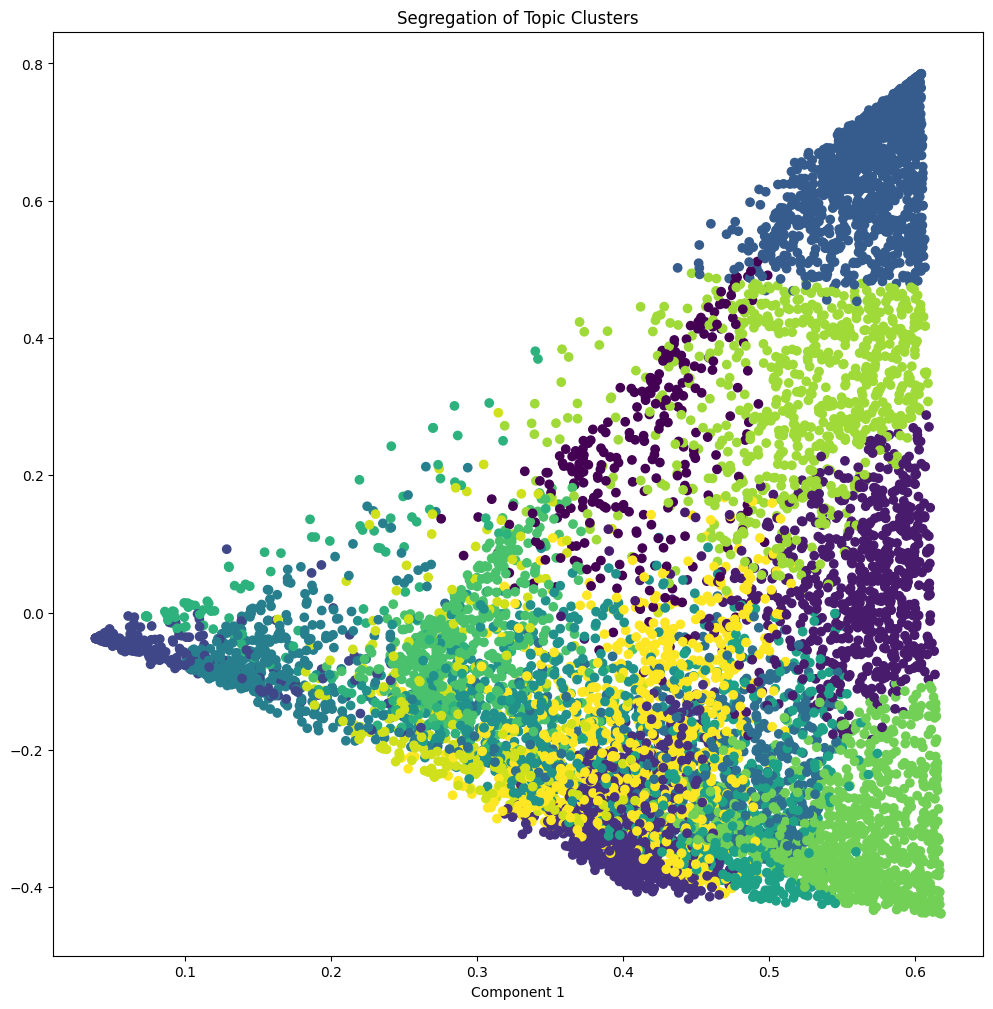

In [31]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("토픽 군집 분리", )

#### 주어진 텍스트와 유사한 문서 분석

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

# nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = nouns, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        # print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [ ]:
# Get similar documents
mytext = ["대전에 놀러온 김에 숲체원에 다녀왔어요. 우리 애들이 숲에서 노는 걸 보니 참 좋더라구요."]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = nouns, top_n=1, verbose=True)
print('\n', docs[0][:500])

In [ ]:
df_document_topic.head()

In [32]:
df_topic_keywords_t = df_topic_keywords.T
df_topic_keywords_t


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6
notext,0.142858,0.142858,0.142858,0.142858,45.553502,0.142859,0.142858
가가,73.314340,32.789314,0.143966,0.143321,0.143524,0.150446,57.057690
가가린,0.145564,6.387210,0.142888,0.143106,0.143181,0.143028,0.143159
가가호호,10.168471,0.143278,0.143655,0.143225,0.145706,0.142893,0.143104
가각,0.148358,0.144124,0.142883,0.143506,0.143044,0.142909,2.446665
...,...,...,...,...,...,...,...
힙니,0.143399,1.327554,0.142913,0.142930,0.143044,0.142938,0.142899
힙합,0.144866,5.735407,0.143705,0.143693,0.146186,0.143356,0.142862
힛,0.143570,0.142857,0.142909,0.928384,0.142865,0.142857,0.142947
힛포,0.585173,0.152862,0.142875,0.143113,0.142910,0.142991,0.143024


In [34]:
df_topic_keywords_t.to_csv("D:/2022산림복지 GridSearch-LDA 토픽모델링.txt", sep='\t', encoding='UTF-8')

In [35]:
import pandas as pd
df_topic_keywords_t = pd.read_csv("D:/2022산림복지 GridSearch-LDA 토픽모델링.txt", sep='\t', encoding='UTF-8')
df_topic_keywords_t.head()


,Unnamed: 0,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6
0,notext,0.142858,0.142858,0.142858,0.142858,45.553502,0.142859,0.142858
1,가가,73.314340,32.789314,0.143966,0.143321,0.143524,0.150446,57.057690
2,가가린,0.145564,6.387210,0.142888,0.143106,0.143181,0.143028,0.143159
3,가가호호,10.168471,0.143278,0.143655,0.143225,0.145706,0.142893,0.143104
4,가각,0.148358,0.144124,0.142883,0.143506,0.143044,0.142909,2.446665


In [36]:
topic0DF = df_topic_keywords_t[['Unnamed: 0', 'Topic0']]
topic0DF.sort_values(by='Topic0', inplace=True, ascending=False)
topic0_top20 = topic0DF.head(20)
topic0_top20.reset_index(inplace=True)
topic0_top20.columns = ['idx', '단어0', 'Topic0']
topic0_top20.reset_index(inplace=True)
# topic0_top20 = topic0_top20[['index', '단어0', 'Topic0']]
# topic0_top20

topic1DF = df_topic_keywords_t[['Unnamed: 0', 'Topic1']]
topic1DF.sort_values(by='Topic1', inplace=True, ascending=False)
topic1_top20 = topic1DF.head(20)
topic1_top20.reset_index(inplace=True)
topic1_top20.columns = ['idx', '단어1', 'Topic1']
topic1_top20.reset_index(inplace=True)

topic2DF = df_topic_keywords_t[['Unnamed: 0', 'Topic2']]
topic2DF.sort_values(by='Topic2', inplace=True, ascending=False)
topic2_top20 = topic2DF.head(20)
topic2_top20.reset_index(inplace=True)
topic2_top20.columns = ['idx', '단어2', 'Topic2']
topic2_top20.reset_index(inplace=True)

topic3DF = df_topic_keywords_t[['Unnamed: 0', 'Topic3']]
topic3DF.sort_values(by='Topic3', inplace=True, ascending=False)
topic3_top20 = topic3DF.head(20)
topic3_top20.reset_index(inplace=True)
topic3_top20.columns = ['idx', '단어3', 'Topic3']
topic3_top20.reset_index(inplace=True)

topic4DF = df_topic_keywords_t[['Unnamed: 0', 'Topic4']]
topic4DF.sort_values(by='Topic4', inplace=True, ascending=False)
topic4_top20 = topic4DF.head(20)
topic4_top20.reset_index(inplace=True)
topic4_top20.columns = ['idx', '단어4', 'Topic4']
topic4_top20.reset_index(inplace=True)

topic5DF = df_topic_keywords_t[['Unnamed: 0', 'Topic5']]
topic5DF.sort_values(by='Topic5', inplace=True, ascending=False)
topic5_top20 = topic5DF.head(20)
topic5_top20.reset_index(inplace=True)
topic5_top20.columns = ['idx', '단어5', 'Topic5']
topic5_top20.reset_index(inplace=True)

topic6DF = df_topic_keywords_t[['Unnamed: 0', 'Topic6']]
topic6DF.sort_values(by='Topic6', inplace=True, ascending=False)
topic6_top20 = topic6DF.head(20)
topic6_top20.reset_index(inplace=True)
topic6_top20.columns = ['idx', '단어6', 'Topic6']
topic6_top20.reset_index(inplace=True)

# topic7DF = df_topic_keywords_t[['Unnamed: 0', 'Topic7']]
# topic7DF.sort_values(by='Topic7', inplace=True, ascending=False)
# topic7_top20 = topic7DF.head(20)
# topic7_top20.reset_index(inplace=True)
# topic7_top20.columns = ['idx', '단어7', 'Topic7']
# topic7_top20.reset_index(inplace=True)

# topic8DF = df_topic_keywords_t[['Unnamed: 0', 'Topic8']]
# topic8DF.sort_values(by='Topic8', inplace=True, ascending=False)
# topic8_top20 = topic8DF.head(20)
# topic8_top20.reset_index(inplace=True)
# topic8_top20.columns = ['idx', '단어8', 'Topic8']
# topic8_top20.reset_index(inplace=True)

# topic9DF = df_topic_keywords_t[['Unnamed: 0', 'Topic9']]
# topic9DF.sort_values(by='Topic9', inplace=True, ascending=False)
# topic9_top20 = topic9DF.head(20)
# topic9_top20.reset_index(inplace=True)
# topic9_top20.columns = ['idx', '단어9', 'Topic9']
# topic9_top20.reset_index(inplace=True)



C:\Users\user\AppData\Local\Temp\ipykernel_18364\2209069069.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic0DF.sort_values(by='Topic0', inplace=True, ascending=False)
C:\Users\user\AppData\Local\Temp\ipykernel_18364\2209069069.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic1DF.sort_values(by='Topic1', inplace=True, ascending=False)
C:\Users\user\AppData\Local\Temp\ipykernel_18364\2209069069.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [ ]:
topic0DF = df_topic_keywords_t[['Topic0']]
topic0DF.sort_values(by='Topic0', inplace=True, ascending=False)
topic0_top20 = topic0DF.head(20)
topic0_top20.reset_index(inplace=True)
topic0_top20.columns = ['단어0', 'Topic0']
topic0_top20.reset_index(inplace=True)

topic1DF = df_topic_keywords_t[['Topic1']]
topic1DF.sort_values(by='Topic1', inplace=True, ascending=False)
topic1_top20 = topic1DF.head(20)
topic1_top20.reset_index(inplace=True)
topic1_top20.columns = ['단어1', 'Topic1']
topic1_top20.reset_index(inplace=True)

topic2DF = df_topic_keywords_t[['Topic2']]
topic2DF.sort_values(by='Topic2', inplace=True, ascending=False)
topic2_top20 = topic2DF.head(20)
topic2_top20.reset_index(inplace=True)
topic2_top20.columns = ['단어2', 'Topic2']
topic2_top20.reset_index(inplace=True)

topic3DF = df_topic_keywords_t[['Topic3']]
topic3DF.sort_values(by='Topic3', inplace=True, ascending=False)
topic3_top20 = topic3DF.head(20)
topic3_top20.reset_index(inplace=True)
topic3_top20.columns = ['단어3', 'Topic3']
topic3_top20.reset_index(inplace=True)

topic4DF = df_topic_keywords_t[['Topic4']]
topic4DF.sort_values(by='Topic4', inplace=True, ascending=False)
topic4_top20 = topic4DF.head(20)
topic4_top20.reset_index(inplace=True)
topic4_top20.columns = ['단어4', 'Topic4']
topic4_top20.reset_index(inplace=True)

topic5DF = df_topic_keywords_t[['Topic5']]
topic5DF.sort_values(by='Topic5', inplace=True, ascending=False)
topic5_top20 = topic5DF.head(20)
topic5_top20.reset_index(inplace=True)
topic5_top20.columns = ['단어5', 'Topic5']
topic5_top20.reset_index(inplace=True)

topic6DF = df_topic_keywords_t[['Topic6']]
topic6DF.sort_values(by='Topic6', inplace=True, ascending=False)
topic6_top20 = topic6DF.head(20)
topic6_top20.reset_index(inplace=True)
topic6_top20.columns = ['단어6', 'Topic6']
topic6_top20.reset_index(inplace=True)

topic7DF = df_topic_keywords_t[['Topic7']]
topic7DF.sort_values(by='Topic7', inplace=True, ascending=False)
topic7_top20 = topic7DF.head(20)
topic7_top20.reset_index(inplace=True)
topic7_top20.columns = ['단어7', 'Topic7']
topic7_top20.reset_index(inplace=True)

topic8DF = df_topic_keywords_t[['Topic8']]
topic8DF.sort_values(by='Topic8', inplace=True, ascending=False)
topic8_top20 = topic8DF.head(20)
topic8_top20.reset_index(inplace=True)
topic8_top20.columns = ['단어8', 'Topic8']
topic8_top20.reset_index(inplace=True)

topic9DF = df_topic_keywords_t[['Topic9']]
topic9DF.sort_values(by='Topic9', inplace=True, ascending=False)
topic9_top20 = topic9DF.head(20)
topic9_top20.reset_index(inplace=True)
topic9_top20.columns = ['단어9', 'Topic9']
topic9_top20.reset_index(inplace=True)


In [37]:
# topicDF = pd.concat([topic0_top20, topic1_top20, topic2_top20, topic3_top20, topic4_top20, topic5_top20, topic6_top20, topic7_top20, topic8_top20, topic9_top20], axis=1)
topicDF = pd.concat([topic0_top20, topic1_top20, topic2_top20, topic3_top20, topic4_top20, topic5_top20, topic6_top20], axis=1)
topicDF


,index,idx,단어0,Topic0,index,idx,단어1,Topic1,index,idx,...,단어4,Topic4,index,idx,단어5,Topic5,index,idx,단어6,Topic6
0,0,36782,숲,14620.098322,0,31029,사회,5994.039969,0,31150,...,사업,19024.796059,0,71302,학과,11079.707157,0,2995,경우,9545.923038
1,1,4155,곳,10697.800735,1,14667,대한,5842.488159,1,27742,...,지역,14561.184735,1,71355,학부,7277.693895,1,37921,시설,9448.244038
2,2,8369,길,7430.103859,2,34194,세계,5702.529799,2,59760,...,지원,11629.107267,2,55251,전공,6435.687398,2,30767,사업,6671.617918
3,3,62521,체험,6505.790708,3,22560,문제,4898.726631,3,64205,...,추진,9884.889318,3,55795,전형,5592.667895,3,26407,법,6473.613101
4,4,10664,나무,5481.265173,4,74862,환경,4876.802102,4,38811,...,조성,9085.127694,4,14648,대학,5582.359161,4,67189,토지,5926.480815
5,5,30522,사람,5434.822363,5,30522,사람,4829.705745,5,71498,...,원,8475.274360,5,71368,학생,5345.137828,5,58720,주택,5888.297267
6,6,31150,산림,5393.002111,6,19886,말,4515.517357,6,5465,...,면,8108.694128,6,5465,교육,4852.401758,6,59721,지역,5590.012563
7,7,19475,마음,5263.041387,7,48076,위해,4154.929668,7,36782,...,산불,7954.067103,7,28134,부,4751.799725,7,3368,계획,5442.653521
8,8,31066,산,4893.722495,8,3050,경제,4013.348540,8,60406,...,산업,7858.982940,8,21379,모집,4106.831166,8,38101,시행,5061.069478
9,9,19473,마을,4644.319983,9,6069,국가,3923.486347,9,7830,...,위해,6835.739787,9,53557,자연,3568.703903,9,72296,해당,4994.681509


In [38]:
topicDF.to_csv("D:/2018-22산림복지/2022산림복지 GridSearch-LDA-coherence 1차.txt", sep='\t', encoding='UTF-8')
topicDF.to_excel("D:/2018-22산림복지/2022산림복지 GridSearch-LDA-coherence 1차.xlsx")
